In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
import io
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# temp_dir = "C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_"  # Thư mục lưu file tạm

input_files = [f"file{i+1}.csv" for i in range(3)]

temp_dir =  "/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_"

input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)
df = [dk.read_csv(file) for file in input_files]

# input_zip = "/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type.zip"
# csv_files = []
# with zipfile.ZipFile(input_zip, 'r') as z:
#     csv_files = [f for f in z.namelist() if f.endswith('.csv')]
# print(csv_files)
# df = [dk.read_csv(f'zip://{file}::{input_zip}') for file in csv_files]
# print(df[0].shape)

2025-04-14 12:43:36.659258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744634616.676490    7798 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744634616.680876    7798 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744634616.696135    7798 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744634616.696161    7798 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744634616.696163    7798 computation_placer.cc:177] computation placer alr

['/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_file1.csv', '/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_file2.csv', '/mnt/c/Users/hoang/FileCSV_DACN_2025/2Type_file3.csv']


In [2]:
batch_size = 512
ratio_test_all = 0.15

from dask_ml.model_selection import train_test_split 
# Split 
train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42, shuffle=True)

# def dask_to_tf_dataset(dask_df, batch_size, num_classes): 
#     def generator():
#         for batch in dask_df.to_delayed():
#             batch=batch.compute()  
#             if batch.empty:
#                 continue

#             X = batch.drop(columns='label').values.astype(np.float32)
#             y = batch['label'].values
#             y_onehot = to_categorical(y, num_classes=num_classes)  

#             num_splits = max(1, len(X) // batch_size)  # Đảm bảo không chia nhỏ quá mức
#             X_batches = np.array_split(X, num_splits)
#             y_batches = np.array_split(y_onehot, num_splits)

#             for X_batch, y_batch in zip(X_batches, y_batches):
#                 yield X_batch, y_batch
                
#     output_signature = ( 
#         tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
#         tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
#     )
    
#     return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)


############## binary ########################
# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
############ binary ###########

In [3]:
# train_df1, test_df1 = df1.random_split([1 - ratio_test_all, ratio_test_all])
# train_df2, test_df2 = df2.random_split([1 - ratio_test_all, ratio_test_all])
# train_df3, test_df3 = df3.random_split([1 - ratio_test_all, ratio_test_all])
train_dfs = []
test_dfs = []
for dff in df:
    train_df, test_df =dff.random_split([1 - ratio_test_all, ratio_test_all])
    train_dfs.append(train_df)
    test_dfs.append(test_df)
   

train_gens = [dask_to_tf_dataset(train_df, 512).repeat() for train_df in train_dfs]

test_gens = [dask_to_tf_dataset(test_df , 512) for test_df in test_dfs]

I0000 00:00:1744634624.132701    7798 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5


In [4]:
import datetime
import numpy as np
import tenseal as ts
#
from server import Server
from client import Client
num_servers = 1
num_clients = 3

stepsPerEpoch_Clients = [int( np.ceil(train_dfs[index].shape[0] / batch_size)) for index in range(num_clients)]

active_servers_list  = ['server_'+str(i)\
                        for i in range(num_servers)]
active_clients_list  = ['client_'+str(i)\
                        for i in range(num_clients)]

print(active_servers_list)
print(active_clients_list)

def init_he_context():
    """Thiết lập context mã hóa đồng hình"""
    context = ts.context(
        ts.SCHEME_TYPE.CKKS, # ckks cho số thực, bfv cho int
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.generate_galois_keys()
    context.global_scale = 2**40
    return context

context = init_he_context()
agents_dict= {}
serverObjects={}
clientObjects={}
serverObjects = {server_name: Server(server_name=server_name, \
                        active_clients_list=active_clients_list) \
                        for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], test_gens[clientID], \
                        active_clients_list = active_clients_list, he_context=context) \
                        for clientID, client_name in enumerate(active_clients_list)}

for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].set_steps_per_epoch(stepsPerEpoch_Clients[index])
    clientObjects[client_name].get_steps_per_epoch()
    
# lưu dict
agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

# init agents_dict vừa tạo vào client, server
for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

client_name = 'client_1'
print("Agent_Dict: ", agents_dict['client'][client_name])

server = agents_dict['server']['server_0']
print(server)

['server_0']
['client_0', 'client_1', 'client_2']
11945
23893
35840
Agent_Dict:  <client.Client object at 0x7f5875342ca0>


In [ ]:
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()

====================================== Đang chạy Iteration 1 ======================================
Epoch 1/5
Epoch 1/5
Epoch 1/5


I0000 00:00:1744634764.813498    7881 service.cc:152] XLA service 0x7f56b8007a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744634764.813662    7881 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-14 12:46:04.914222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744634765.369256    7880 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/239 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5048 - loss: 0.8580s: 0.80

2025-04-14 12:46:09.646078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

2025-04-14 12:46:09.667252: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

I0000 00:00:1744634769.668662    7880 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-14 12:46:09.677728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



226/359 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8453 - loss: 0.3889

2025-04-14 12:46:12.422001: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


243/359 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8522 - loss: 0.3759

2025-04-14 12:46:12.788789: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 85/239 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6921 - loss: 0.6194

2025-04-14 12:46:13.761438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads



239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8300 - loss: 0.4140
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7326 - loss: 0.5606Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7374 - loss: 0.5543
Epoch 2/5
  1/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9824 - loss: 0.1235

2025-04-14 12:46:15.074057: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



304/359 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8719 - loss: 0.3369

2025-04-14 12:46:16.073620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9866 - loss: 0.0922
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8851 - loss: 0.3090
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9878 - loss: 0.0565
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9893 - loss: 0.0500
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9885 - loss: 0.0529
242/359 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9899 - loss: 0.0466Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9892 - loss: 0.0500
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9904 - loss: 0.0456
Epoch 3/5
 11/359 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9933 - loss: 0.0395client_0Come end!
 35/359 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9925 - loss: 0.03712

2025-04-14 12:46:22.978605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9899 - loss: 0.0456
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9912 - loss: 0.0384
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9890 - loss: 0.0492
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9906 - loss: 0.0443
client_1Come end!
 91/359 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9926 - loss: 0.0410

2025-04-14 12:46:33.342429: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9922 - loss: 0.0405
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9922 - loss: 0.0373
client_2Come end!
  24/6000 ━━━━━━━━━━━━━━━━━━━━ 1:48 18ms/step - accuracy: 0.9946 - loss: 11.5937

2025-04-14 12:46:50.612423: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 101s 48ms/step - accuracy: 0.9886 - loss: 0.1312
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 179s 44ms/step - accuracy: 0.9853 - loss: 0.0549
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.9938 - loss: 0.3062
  62/4000 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.9952 - loss: 0.1786 s: 7.90Arguments:  Performance Metrics for client_0 on iteration 1 
------------------------------------------- 
local accuracy: 0.9885470271110535 
global accuracy: 0.9938300251960754 
local compute time: 0:00:30.919081 
Simulated time to receive global weights: 0:00:52.350292 
 

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 230s 38ms/step - accuracy: 0.9947 - loss: 7.4144
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 141s 34ms/step - accuracy: 0.9952 - loss: 0.1780
2331/6000 ━━━━━━━━━━━━━━━━━━━━ 2:18 38ms/step - accuracy: 0.9828 - loss: 0.4071Arguments:  Performance Metrics for client_1 on iteration 1 
------------------------------------------- 
local accuracy: 0.985338568687439 
global accuracy: 0.

2025-04-14 12:54:01.827821: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

2025-04-14 12:54:01.845747: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads

2025-04-14 12:54:01.897978: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



 70/239 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7465 - loss: 0.5251

2025-04-14 12:54:07.385447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 168 bytes spill stores, 168 bytes spill loads



 76/239 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7557 - loss: 0.5139

2025-04-14 12:54:07.613977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7882 - loss: 0.4750
Epoch 2/5
 55/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9900 - loss: 0.0816

2025-04-14 12:54:09.371287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9040 - loss: 0.2715
195/239 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8541 - loss: 0.3632Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9897 - loss: 0.0734
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8716 - loss: 0.3292
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9932 - loss: 0.0438
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9908 - loss: 0.0379
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9911 - loss: 0.0414
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9889 - loss: 0.0495
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9887 - loss: 0.0445
client_0Come end!
 17/239 ━━━━━━━━━━━━━━━━━━━━ 51s 234ms/step - accuracy: 0.9943 - loss: 0.0310 

2025-04-14 12:54:24.588774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 96 bytes spill stores, 96 bytes spill loads



239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9932 - loss: 0.0352
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9904 - loss: 0.0469
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9913 - loss: 0.0417
Epoch 5/5
 79/359 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.9918 - loss: 0.0516

2025-04-14 12:54:35.809052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_transpose_fusion', 88 bytes spill stores, 88 bytes spill loads



239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9917 - loss: 0.0404
148/359 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9913 - loss: 0.0517client_1Come end!
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9906 - loss: 0.0511
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9899 - loss: 0.0488
client_2Come end!
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.9836 - loss: 0.0629
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 194s 46ms/step - accuracy: 0.9906 - loss: 0.0492
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 102s 49ms/step - accuracy: 0.9831 - loss: 0.0639
4403/6000 ━━━━━━━━━━━━━━━━━━━━ 1:12 45ms/step - accuracy: 0.9827 - loss: 0.1418Arguments:  Performance Metrics for client_0 on iteration 2 
------------------------------------------- 
local accuracy: 0.9836706519126892 
global accuracy: 0.9831669926643372 
local compute time: 0:00:36.372118 
Simulated time to receive global weights: 0:00:58.750534 
 

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 284s 46ms/step - accura

KeyboardInterrupt: 

3272/6000 ━━━━━━━━━━━━━━━━━━━━ 1:29 33ms/step - accuracy: 0.9817 - loss: 0.1052

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

import numpy as np

num_batch_test_eachClient  =  []
for index, test_df in enumerate(test_dfs):
    num_samples_test = test_df.shape[0].compute()
    # Tính số batch
    num_batches_test = int(np.ceil(num_samples_test / batch_size))
    num_batch_test_eachClient.append(num_batches_test)
    
X_tests = {}
Y_tests = {}

for i, client_name in enumerate(active_clients_list):
    X_true_all = []
    y_pred_all = []

    for X_batch, y_batch in test_gens[i].take(num_batch_test_eachClient[i]):
    # .as_numpy_iterator():
        # # take(12000):
        # X_test_list.append(X_batch.numpy())
        # y_test_list.append(y_batch.numpy())  # .numpy()

        # # Gộp tất cả batch lại
        # X_test = np.concatenate(X_test_list, axis=0)
        # y_test = np.concatenate(y_test_list, axis=0)

        # # Nếu y_test đang ở dạng one-hot, chuyển về dạng số
        # y_test = np.argmax(y_test, axis=1)
        
        y_true_all.extend(y_batch.numpy().flatten())
        y_pred_prob = model.predict(X_batch, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        y_pred_all.extend(y_pred)
    
    X_tests[client_name] = X_test
    Y_tests[client_name] = y_test

In [ ]:
# tempdirs = ["D:/DoAnChuyenNganh_Train/client_0_log/11h18p__02-04-2025/", "D:/DoAnChuyenNganh_Train/client_1_log/11h18p__02-04-2025/",  "D:/DoAnChuyenNganh_Train/client_2_log/11h18p__02-04-2025/"]
timeFolder="16h53p__13-04-2025/"
tempdirs = [f"/mnt/d/DoAnChuyenNganh_Train/client_{i}_log/" for i in range(3)]


model_names =[f"model_{i}.keras" for i in range(5)]
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models)

8070/8070 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
   1/8070 ━━━━━━━━━━━━━━━━━━━━ 3:02 23ms/step

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8070/8070 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
8070/8070 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
8070/8070 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


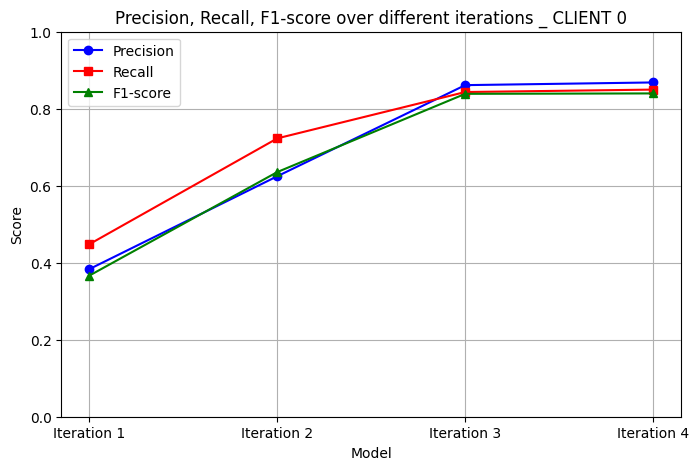

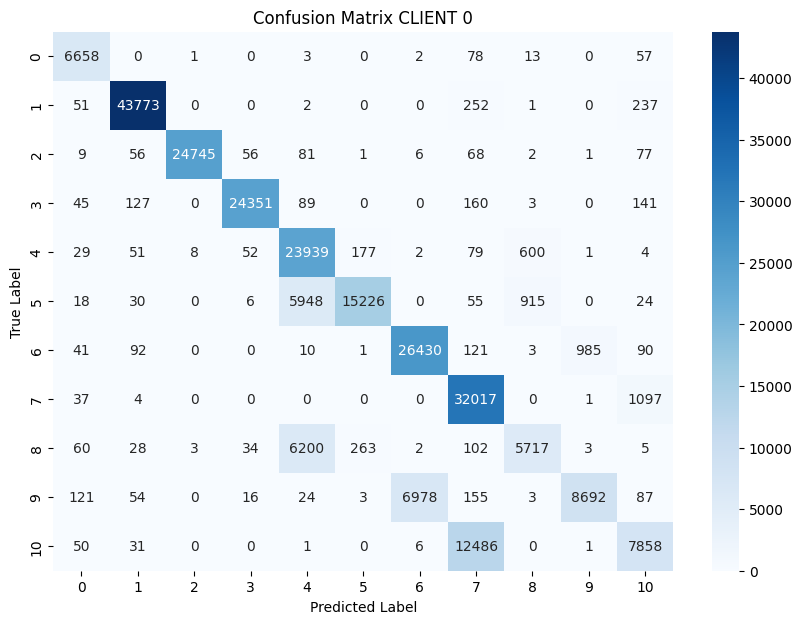

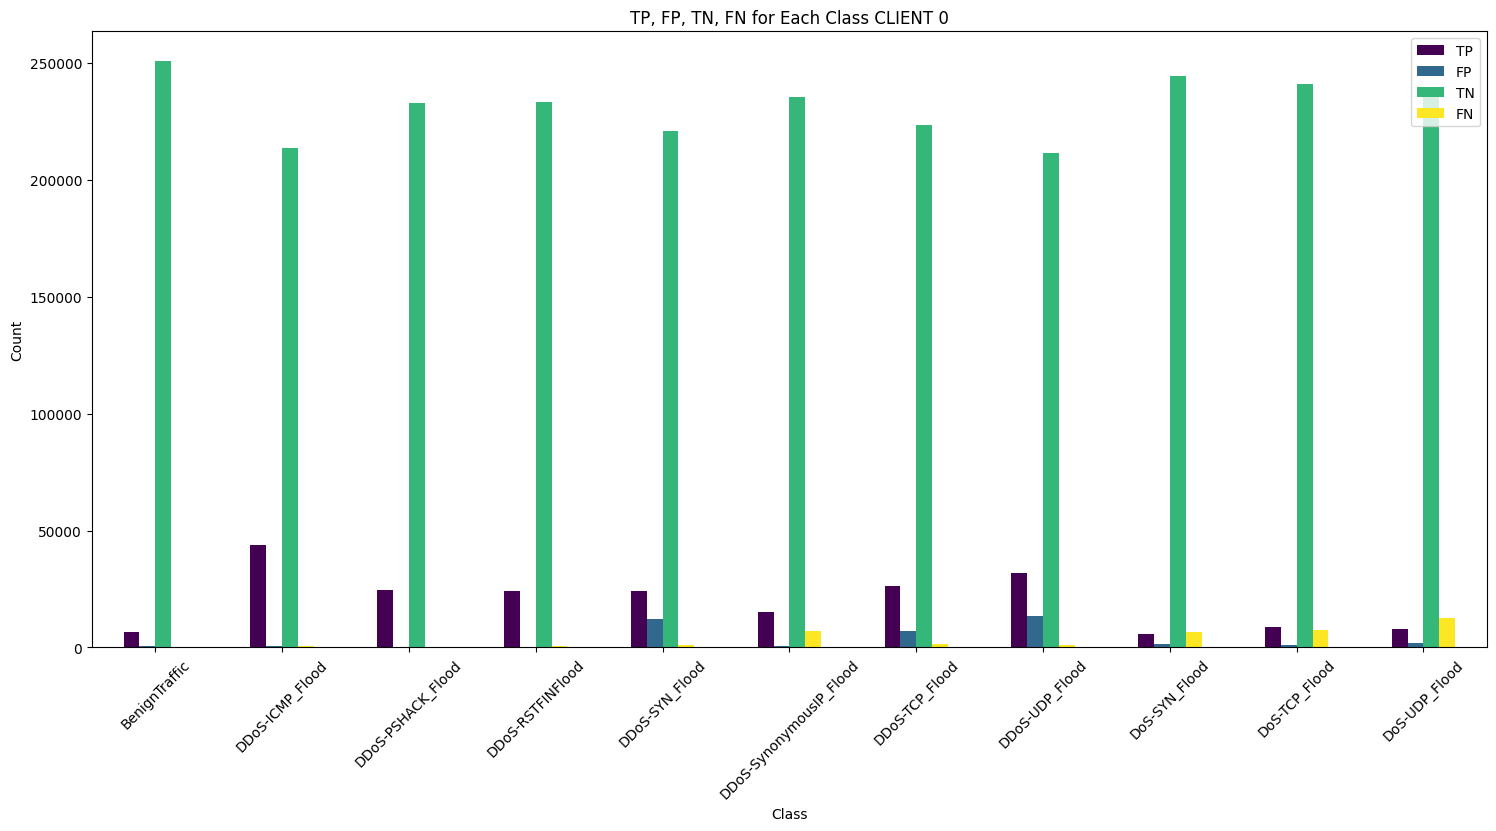

In [ ]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

precisions = []
recalls = []
f1s = []

Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4']
for index in range(len(Iterations)):
    y_pred_prob = models['client_0'][index].predict(X_tests['client_0'])
    # y_pred = y_pred_prob.argmax(axis=1)
    
    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_0'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_0'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_0'], y_pred, average='weighted'))
    
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()



cm = confusion_matrix(Y_tests['client_0'], y_pred)

    # Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.show()


attack_types = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
                   'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(18, 8), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

16119/16119 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16119/16119 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
16119/16119 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
16119/16119 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
Precision Score:  [0.16911087130023533, 0.8758602042586614, 0.8782287750093659, 0.8712383496842514]
Recall Score:  [0.18920931098263205, 0.8534718425369054, 0.8615644715362035, 0.8588326760738147]
F1 Score:  [0.07259208451547194, 0.8422185757758603, 0.8538452791467617, 0.8548416126262781]


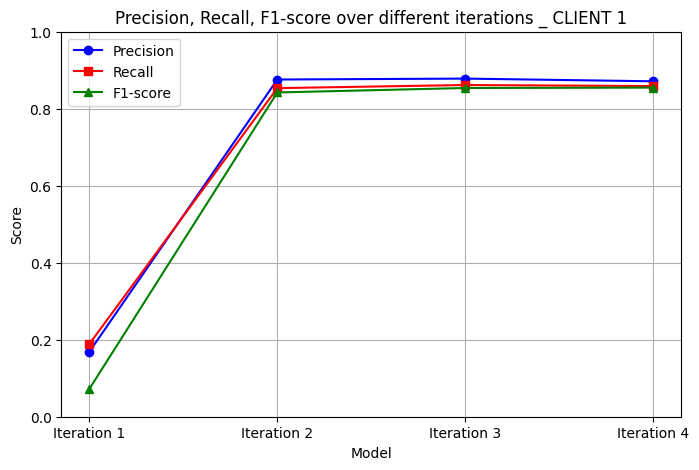

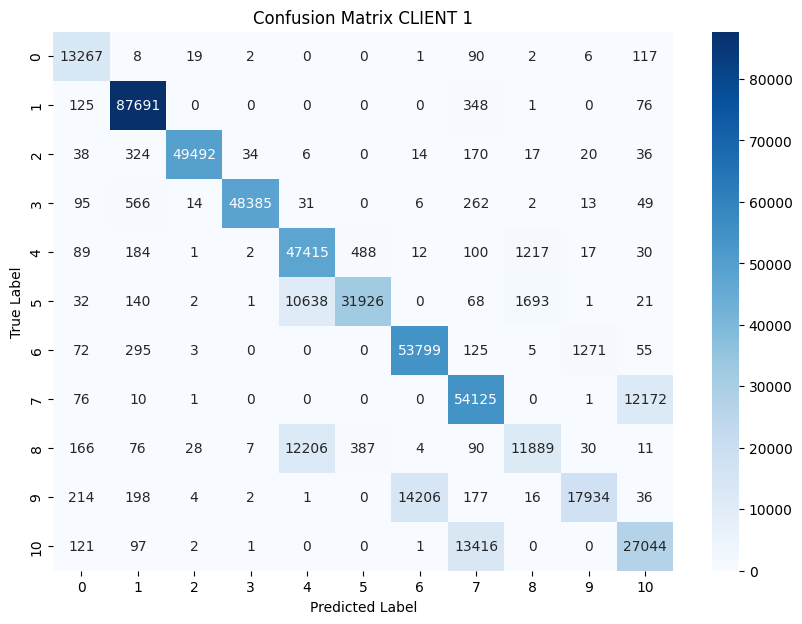

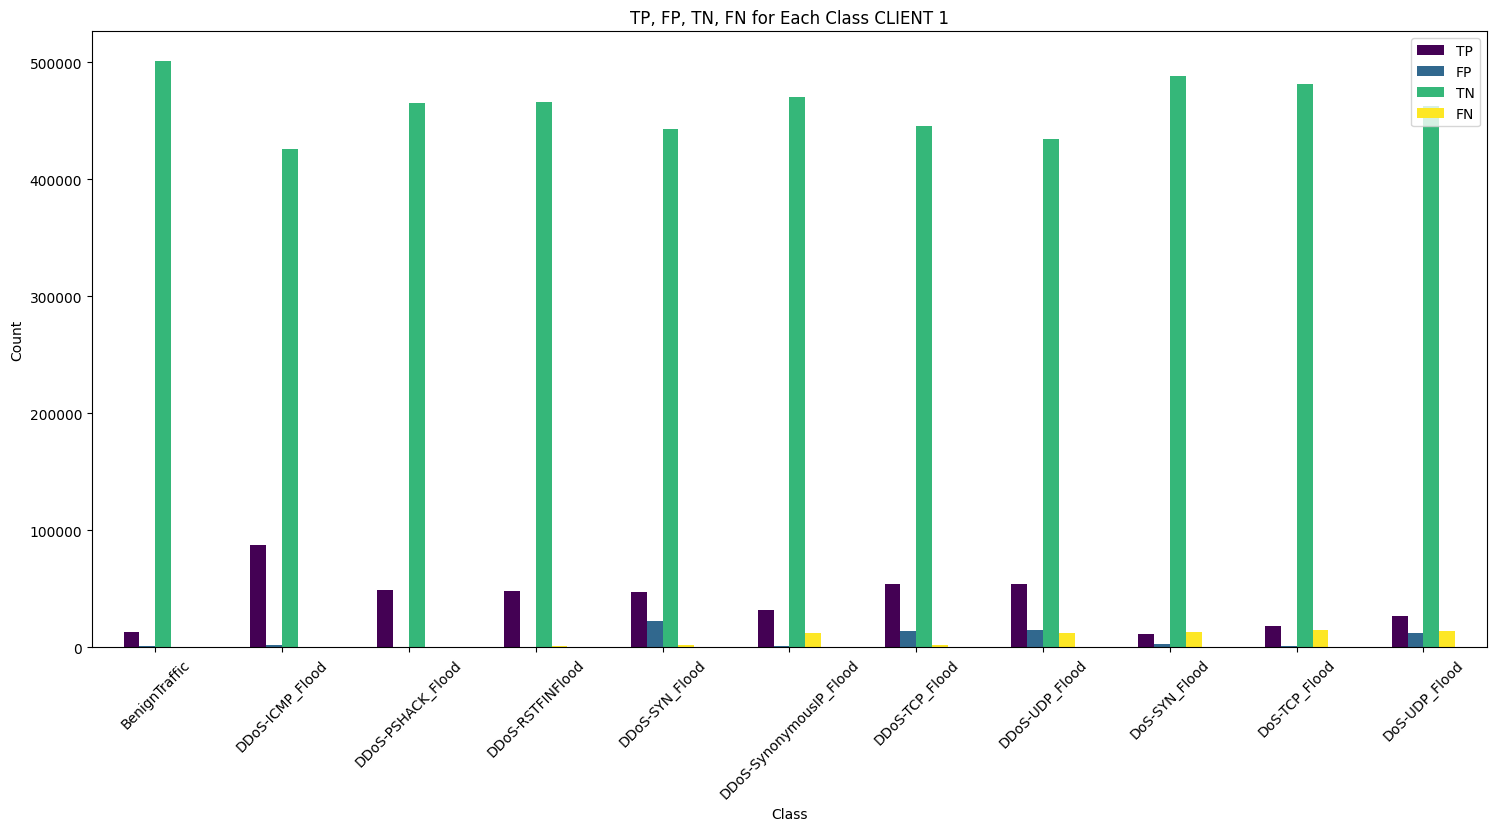

In [22]:
# Client 1
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []
y_pred = []
Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4']
for index in range(len(Iterations)):
    y_pred_prob = models['client_1'][index].predict(X_tests['client_1'])

    y_pred = y_pred_prob.argmax(axis=1)
    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_1'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_1'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_1'], y_pred, average='weighted'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


cm = confusion_matrix(Y_tests['client_1'], y_pred)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


attack_types =['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
                   'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(18, 8), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

24169/24169 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
24169/24169 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
24169/24169 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
24169/24169 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
Precision Score:  [0.8707293976251711, 0.8749992428579575, 0.8751567409037507, 0.8796583275698079]
Recall Score:  [0.8524936093623326, 0.8549373736903557, 0.857791018067047, 0.8628660312879414]
F1 Score:  [0.8421468802166799, 0.8449502034686529, 0.8487599374420904, 0.8569723176333175]


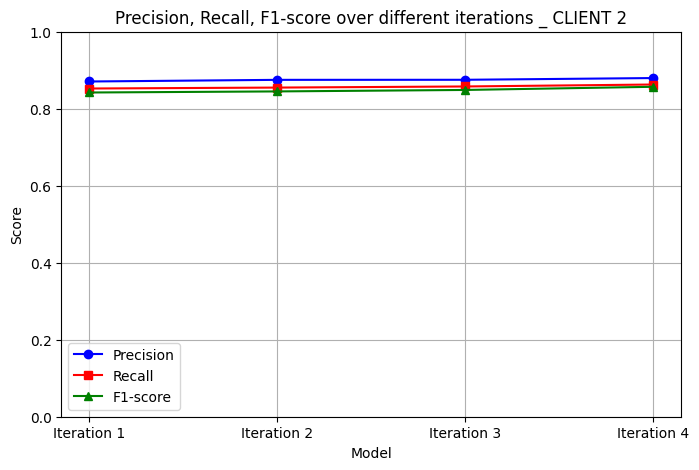

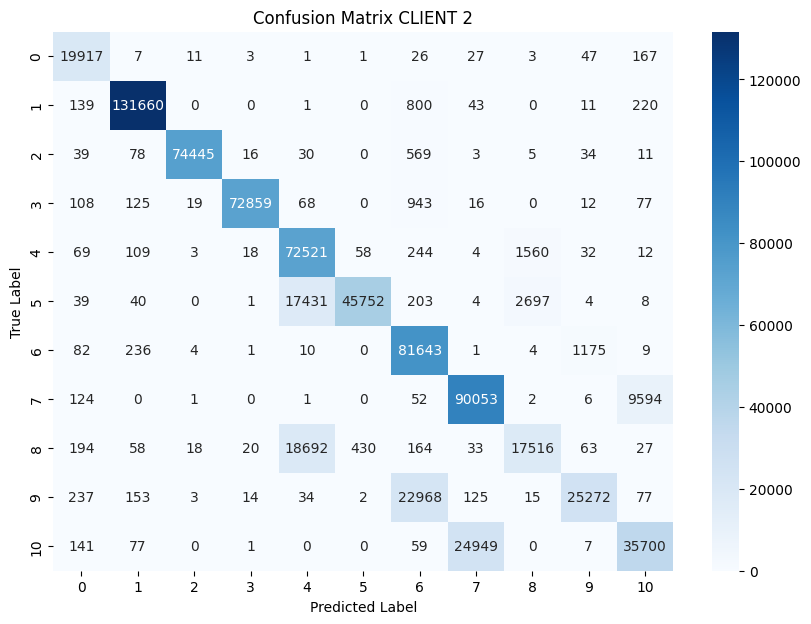

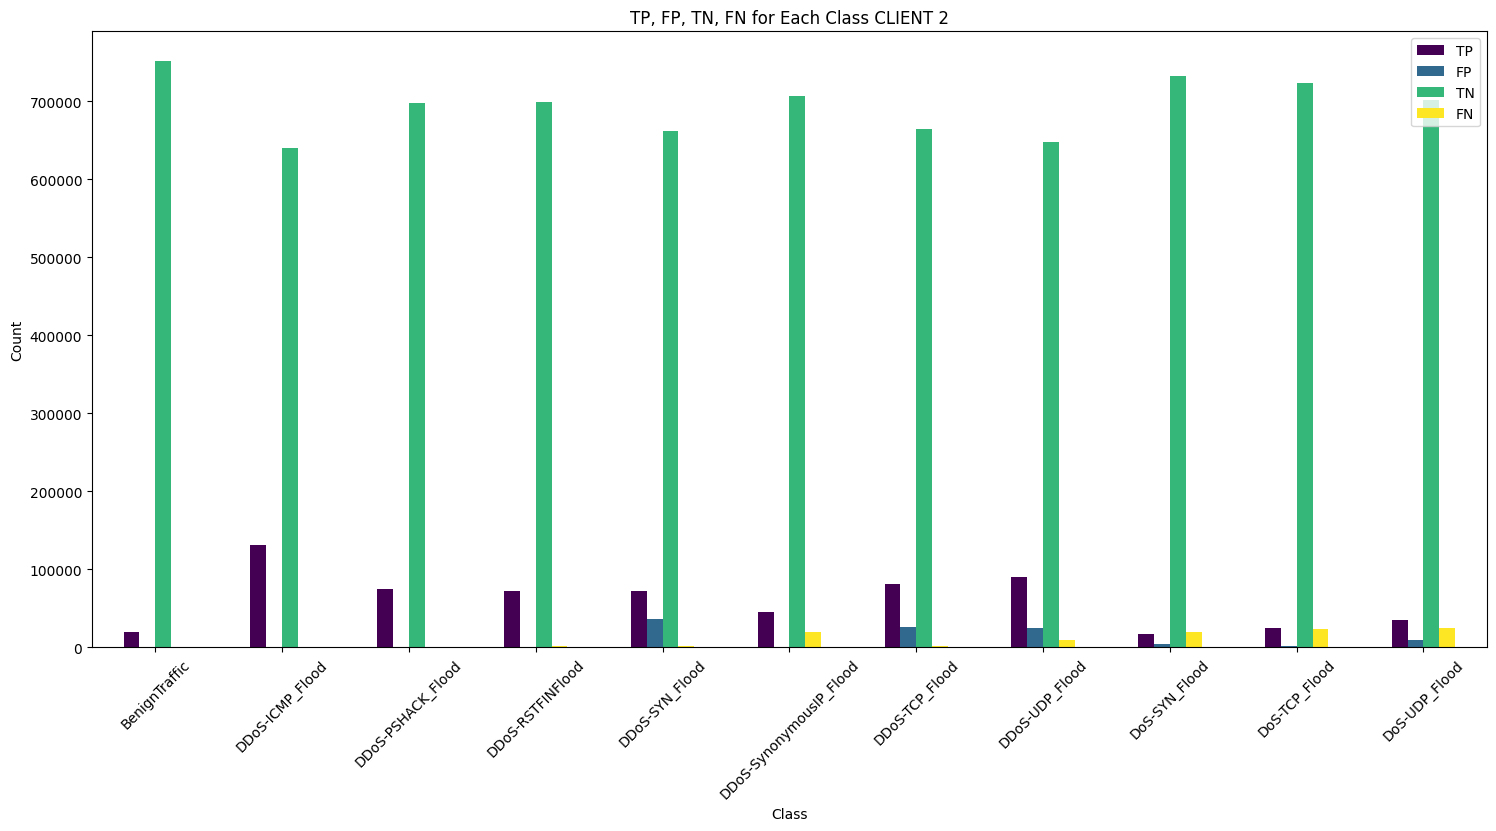

In [23]:
# Client 2
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []
y_pred = []
Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4']
for index in range(len(Iterations)):
    y_pred_prob = models['client_2'][index].predict(X_tests['client_2'])

    y_pred = y_pred_prob.argmax(axis=1)

    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_2'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_2'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_2'], y_pred, average='weighted'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


cm = confusion_matrix(Y_tests['client_2'], y_pred)
# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.show()


#
attack_types =['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
                   'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(18, 8), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7332394123077393 	 Loss: 0.8260282874107361
Epoch_1: Accuracy: 0.758216142654419 	 Loss: 0.7166650891304016
Epoch_2: Accuracy: 0.7608925700187683 	 Loss: 0.6982738375663757
Epoch_3: Accuracy: 0.7610103487968445 	 Loss: 0.6941430568695068
Epoch_4: Accuracy: 0.7611401677131653 	 Loss: 0.6889466643333435
Iteration 1: 
Epoch_0: Accuracy: 0.7398970723152161 	 Loss: 0.7816480994224548
Epoch_1: Accuracy: 0.7589716911315918 	 Loss: 0.710433304309845
Epoch_2: Accuracy: 0.7619751691818237 	 Loss: 0.69295734167099
Epoch_3: Accuracy: 0.761717677116394 	 Loss: 0.6876718401908875
Epoch_4: Accuracy: 0.7620770335197449 	 Loss: 0.6829438209533691
Iteration 2: 
Epoch_0: Accuracy: 0.7467150688171387 	 Loss: 0.7705791592597961
Epoch_1: Accuracy: 0.7597188353538513 	 Loss: 0.7060967683792114
Epoch_2: Accuracy: 0.7621172666549683 	 Loss: 0.6934173703193665
Epoch_3: Accuracy: 0.7618876099586487 	 Loss: 0.6874513030052185
Epoch_4: Accuracy: 0.7618139386177063 	 Loss: 0.68041

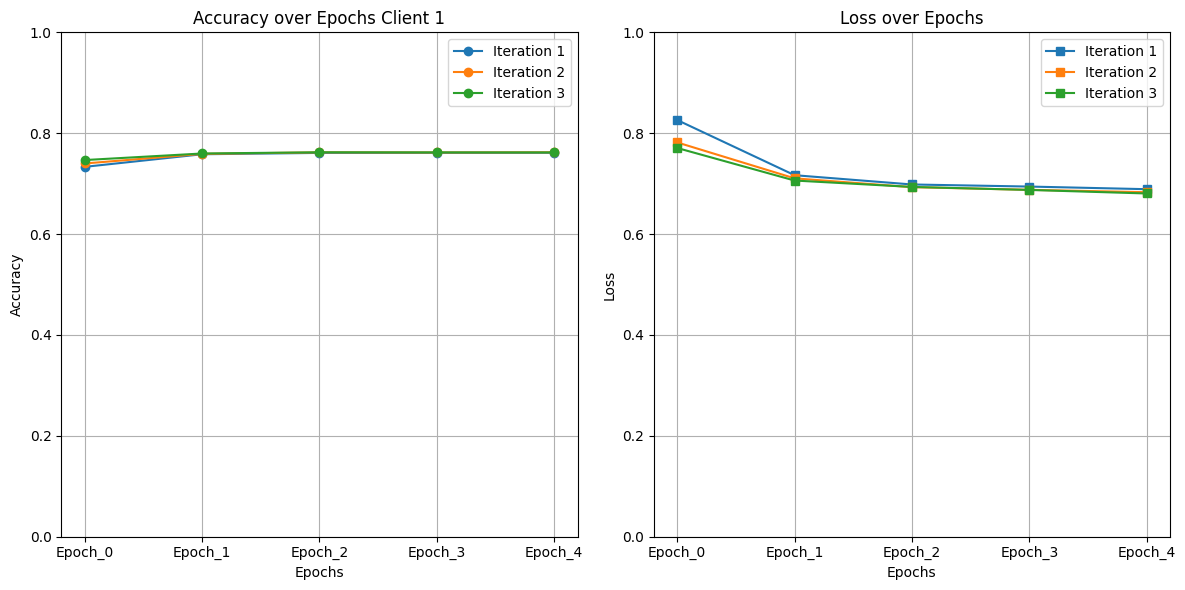

In [ ]:
# Client_0 
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_0_log/11h18p__02-04-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7441520094871521 	 Loss: 0.7800431847572327
Epoch_1: Accuracy: 0.7597604393959045 	 Loss: 0.7049620747566223
Epoch_2: Accuracy: 0.7615246176719666 	 Loss: 0.6933287382125854
Epoch_3: Accuracy: 0.7588609457015991 	 Loss: 0.6797979474067688
Epoch_4: Accuracy: 0.7565250396728516 	 Loss: 0.6744536757469177
Iteration 1: 
Epoch_0: Accuracy: 0.7519223690032959 	 Loss: 0.7438097596168518
Epoch_1: Accuracy: 0.7617146372795105 	 Loss: 0.690902829170227
Epoch_2: Accuracy: 0.7624527215957642 	 Loss: 0.6815375685691833
Epoch_3: Accuracy: 0.7573277354240417 	 Loss: 0.6717609763145447
Epoch_4: Accuracy: 0.7574261426925659 	 Loss: 0.6643138527870178
Iteration 2: 
Epoch_0: Accuracy: 0.7527638673782349 	 Loss: 0.7401202917098999
Epoch_1: Accuracy: 0.759777843952179 	 Loss: 0.6942973732948303
Epoch_2: Accuracy: 0.7609728574752808 	 Loss: 0.6744738817214966
Epoch_3: Accuracy: 0.7622946500778198 	 Loss: 0.6668649315834045
Epoch_4: Accuracy: 0.7596004009246826 	 Loss: 0.68

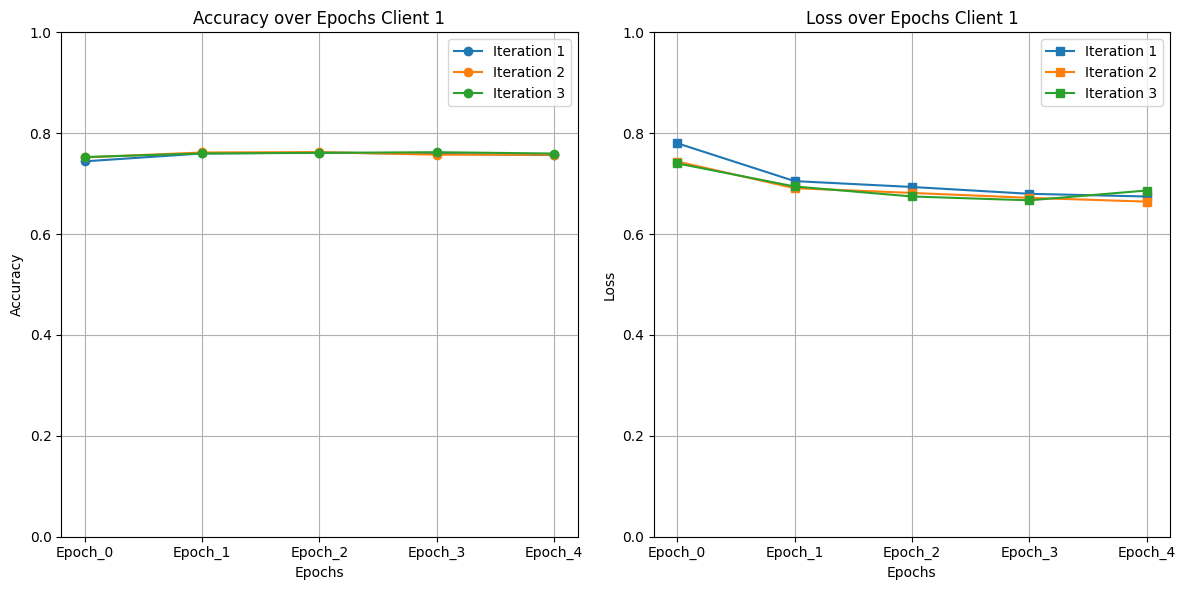

In [ ]:
# Client_1
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_1_log/11h18p__02-04-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7500243782997131 	 Loss: 0.7507213354110718
Epoch_1: Accuracy: 0.7612135410308838 	 Loss: 0.6896445751190186
Epoch_2: Accuracy: 0.7589588761329651 	 Loss: 0.6709281802177429
Epoch_3: Accuracy: 0.7580092549324036 	 Loss: 0.6745122075080872
Epoch_4: Accuracy: 0.7611063718795776 	 Loss: 0.6835665106773376
Iteration 1: 
Epoch_0: Accuracy: 0.7539124488830566 	 Loss: 0.7309588193893433
Epoch_1: Accuracy: 0.759954035282135 	 Loss: 0.6951293349266052
Epoch_2: Accuracy: 0.7585107684135437 	 Loss: 0.6742268800735474
Epoch_3: Accuracy: 0.7596746683120728 	 Loss: 0.6558783054351807
Epoch_4: Accuracy: 0.7651007771492004 	 Loss: 0.6735010743141174
Iteration 2: 
Epoch_0: Accuracy: 0.755957305431366 	 Loss: 0.7246091365814209
Epoch_1: Accuracy: 0.76112300157547 	 Loss: 0.6869326829910278
Epoch_2: Accuracy: 0.7593513131141663 	 Loss: 0.6736646294593811
Epoch_3: Accuracy: 0.7625070810317993 	 Loss: 0.6827905178070068
Epoch_4: Accuracy: 0.7602213621139526 	 Loss: 0.6848

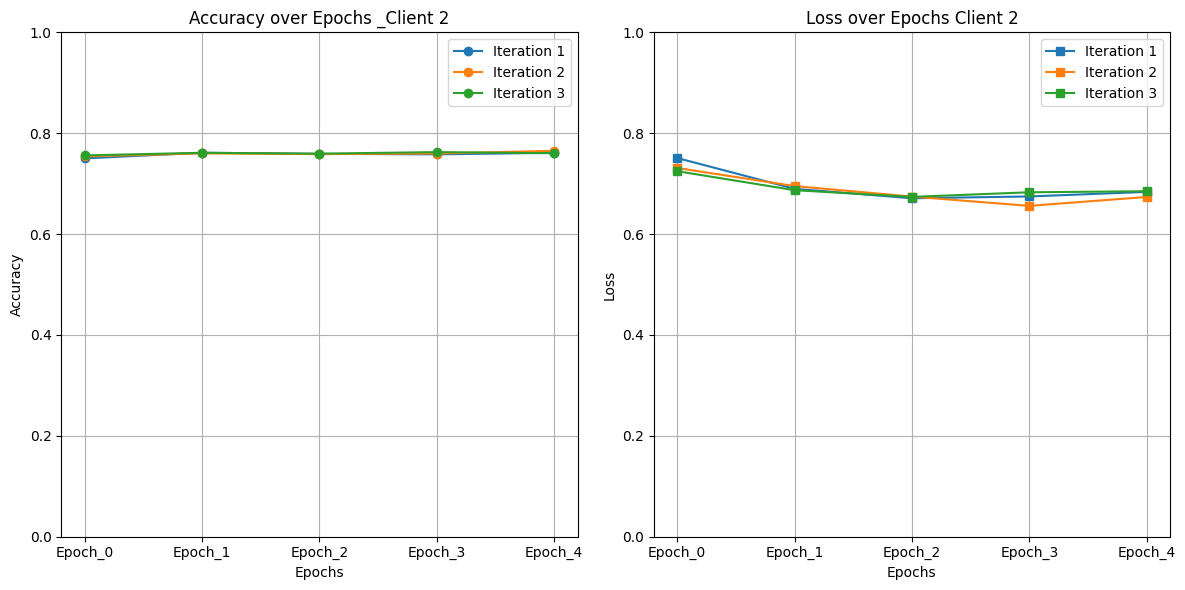

In [ ]:
# Client_2
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_2_log/11h18p__02-04-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs _Client 2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()